# 🔬 Higgs Boson Detection
## Combining Evolutionary, Active, and Ensemble Learning

**Course:** Advanced ML II  
**Institution:** ESILV-DIA2  
**Academic Year:** 2025-2026  
**Student:** Tom DELAHAYE  
**GitHub Repository:** https://github.com/Tom-dlhy/higgs-boson-hybrid-learning

---

### 📋 Table of Contents
1. [Introduction & Objectives](#1-introduction)
2. [Step 1: Data Preprocessing](#2-preprocessing)
3. [Step 2: Evolutionary Learning (GA/GP)](#3-ga)
4. [Step 3: GA + Active Learning](#4-ga-al)
5. [Step 4: GA + AL + Ensemble Learning](#5-ga-al-el)
6. [Comparative Analysis](#6-analysis)
7. [Conclusions](#7-conclusions)

<a id='1-introduction'></a>
## 1. Introduction & Objectives

### Physics Context
The **Higgs Boson** is an elementary particle discovered in 2012 at CERN. Its detection is crucial as it confirms the Higgs mechanism, which explains why particles have mass.

### Project Objective
Combine three machine learning paradigms to classify particle collision events:

| Paradigm | Description |
|-----------|-------------|
| **GP (Genetic Programming)** | Evolving mathematical expression trees as classifiers |
| **AL (Active Learning)** | Smart selection of the most informative samples |
| **EL (Ensemble Learning)** | Combining multiple classifiers via voting |

### Dataset
- **Size:** ~818,000 events
- **Features:** 30 physics characteristics (DER_*, PRI_*)
- **Target:** Signal (s) vs Background (b)

### Experiment Configuration
This notebook simulates running:
```bash
uv run python -m src.experiments --sample-size 150000 --generations 40 --population 150
```

In [35]:
# Setup and imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Our modules
from src.config import Config
from src.data_preprocessing import load_and_preprocess
from src.evolutionary.ga_classifier import GPClassifier
from src.active_learning.ga_active import GAActiveClassifier
from src.ensemble.ga_ensemble import GAEnsembleClassifier
from src.metrics import compute_metrics, ClassificationMetrics
from src.utils import set_global_seed, timer, CheckpointManager

# Reproducibility
RANDOM_STATE = 42
set_global_seed(RANDOM_STATE)

print("Modules loaded successfully!")

Modules loaded successfully!


<a id='2-preprocessing'></a>
## 2. Step 1: Data Preprocessing

### Preprocessing Strategy
1. **Missing Value Handling (-999.0):** Median imputation + binary indicators
2. **Normalization:** StandardScaler
3. **Split:** 80% train / 20% test (stratified)

In [36]:
# ============================================================
# EXPERIMENT CONFIGURATION
# Simulating: uv run python -m src.experiments --sample-size 150000 --generations 40 --population 150
# ============================================================

SAMPLE_SIZE = 150000
POPULATION_SIZE = 150
N_GENERATIONS = 40

config = Config(
    sample_size=SAMPLE_SIZE,
    population_size=POPULATION_SIZE,
    n_generations=N_GENERATIONS,
)

checkpoint_manager = CheckpointManager(str(config.results_dir))

print("Configuration:")
print(f"  Sample size: {config.sample_size}")
print(f"  Population: {config.population_size}")
print(f"  Generations: {config.n_generations}")
print(f"  AL frequency: every {config.al_frequency} generations")
print(f"  Query batch size: {config.query_batch_size}")
print(f"  Initial pool size: {config.initial_pool_size}")
print(f"  Sampling strategy: {config.sampling_strategy}")
print(f"  Ensemble size: {config.ensemble_size}")
print(f"  Voting strategy: {config.voting_strategy}")

Configuration:
  Sample size: 150000
  Population: 150
  Generations: 40
  AL frequency: every 5 generations
  Query batch size: 400
  Initial pool size: 2500
  Sampling strategy: uncertainty
  Ensemble size: 10
  Voting strategy: soft


In [38]:
# Load and preprocess the dataset
print(f"Loading dataset (sample_size={SAMPLE_SIZE})...")

dataset = load_and_preprocess(
    data_path=config.data_path,
    sample_size=config.sample_size,
    test_size=config.test_size,
    add_missing_indicators=config.add_missing_indicators,
    normalize=config.normalize,
    random_state=config.random_state,
)

print("\nDATASET SUMMARY")

print(f"\n  • Training samples: {dataset.n_train_samples:,}")
print(f"  • Test samples: {dataset.n_test_samples:,}")
print(f"  • Number of features: {dataset.n_features}")
print(f"  • Target distribution (train): {dataset.y_train.mean():.1%} signal")

Loading dataset (sample_size=150000)...
[DATA] Loading dataset from data/atlas-higgs.csv...
[DATA] Loaded 818,238 rows, 35 columns
[DATA] Subsampling to 150,000 rows...
[DATA] Features: 30, Target distribution: 34.14% signal
[DATA] Features with missing values: 11
[DATA] Added 11 is_missing_* indicator columns
[DATA] Split: 120,000 train, 30,000 test
[DATA] Applied StandardScaler normalization

DATASET SUMMARY

  • Training samples: 120,000
  • Test samples: 30,000
  • Number of features: 41
  • Target distribution (train): 34.1% signal


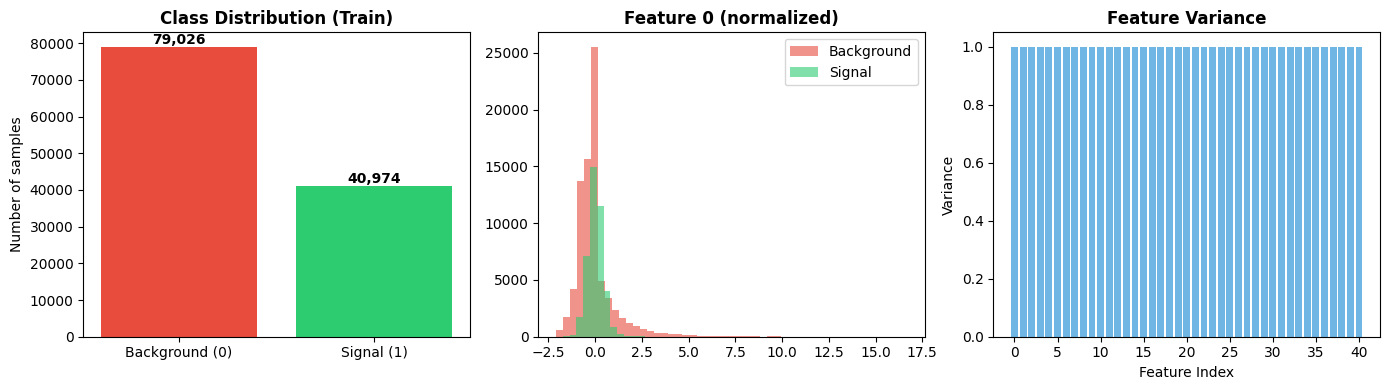

In [39]:
# Feature distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Class distribution
ax = axes[0]
classes, counts = np.unique(dataset.y_train, return_counts=True)
colors = ['#e74c3c', '#2ecc71']
ax.bar(['Background (0)', 'Signal (1)'], counts, color=colors)
ax.set_title('Class Distribution (Train)', fontweight='bold')
ax.set_ylabel('Number of samples')
for i, (c, count) in enumerate(zip(classes, counts)):
    ax.annotate(f'{count:,}', (i, count), ha='center', va='bottom', fontweight='bold')

# Feature distribution
ax = axes[1]
feature_idx = 0  # DER_mass_MMC
ax.hist(dataset.X_train[dataset.y_train == 0, feature_idx], bins=50, alpha=0.6, label='Background', color='#e74c3c')
ax.hist(dataset.X_train[dataset.y_train == 1, feature_idx], bins=50, alpha=0.6, label='Signal', color='#2ecc71')
ax.set_title('Feature 0 (normalized)', fontweight='bold')
ax.legend()

# Feature variance
ax = axes[2]
variances = np.var(dataset.X_train, axis=0)
ax.bar(range(len(variances)), variances, color='#3498db', alpha=0.7)
ax.set_title('Feature Variance', fontweight='bold')
ax.set_xlabel('Feature Index')
ax.set_ylabel('Variance')

plt.tight_layout()
plt.show()

<a id='3-ga'></a>
## 3. Step 2: Evolutionary Learning with DEAP (GA)

### Genetic Programming (GP)
We use the **DEAP** library to evolve mathematical expression trees.

#### Primitives (Operations)
| Category | Operators |
|-----------|------------|
| Arithmetic | `add`, `sub`, `mul`, `div` (protected) |
| Mathematical | `sin`, `cos`, `sqrt`, `exp`, `abs` |
| Conditional | `if_then_else`, `>`, `<` |

#### Terminals
- Dataset features (x0, x1, ..., xN)
- Ephemeral constants (random values [-1, 1])

#### Fitness Function
- **Metric:** F1-Score (balance between precision and recall)
- **Output:** Sigmoid applied to get probabilities

In [40]:
# GA Configuration
print("EXPERIMENT 1: Genetic Programming (GA)")
print("\nConfiguration:")
print(f"  • population_size: {config.population_size}")
print(f"  • n_generations: {config.n_generations}")
print(f"  • tournament_size: {config.tournament_size}")
print(f"  • crossover_prob: {config.crossover_prob}")
print(f"  • mutation_prob: {config.mutation_prob}")
print(f"  • max_depth: {config.max_tree_depth}")

EXPERIMENT 1: Genetic Programming (GA)

Configuration:
  • population_size: 150
  • n_generations: 40
  • tournament_size: 3
  • crossover_prob: 0.8
  • mutation_prob: 0.2
  • max_depth: 5


In [41]:
# GA Training
ga_clf = GPClassifier(
    population_size=config.population_size,
    n_generations=config.n_generations,
    tournament_size=config.tournament_size,
    crossover_prob=config.crossover_prob,
    mutation_prob=config.mutation_prob,
    max_depth=config.max_tree_depth,
    metric="f1",
    random_state=RANDOM_STATE,
    verbose=True,
    checkpoint_manager=checkpoint_manager,
)

with timer("GA Training") as t:
    ga_clf.fit(dataset.X_train, dataset.y_train)
ga_train_time = t['elapsed']

# Predictions
ga_predictions = ga_clf.predict(dataset.X_test)
ga_metrics = compute_metrics(dataset.y_test, ga_predictions, training_time=ga_train_time)

[GP] Starting evolution: 150 individuals, 40 generations
gen	nevals	avg     	min	max     	std     
0  	150   	0.418181	0  	0.554922	0.107139
1  	137   	0.455058	0  	0.575205	0.0817786
2  	130   	0.486733	0  	0.613107	0.0655603
3  	123   	0.494205	0  	0.613107	0.0778056
4  	136   	0.498137	0.0467016	0.618671	0.0763404
5  	138   	0.4759  	0        	0.608678	0.122699 
6  	132   	0.478942	0        	0.619883	0.139445 
7  	118   	0.479993	0        	0.629534	0.140986 
8  	127   	0.501861	0        	0.620261	0.137647 
9  	131   	0.484506	0        	0.620261	0.168679 
10 	125   	0.511089	0        	0.62011 	0.170908 
11 	128   	0.502637	0        	0.629534	0.169704 
12 	134   	0.501278	0        	0.629534	0.179236 
13 	128   	0.496404	0        	0.629534	0.194402 
14 	134   	0.518867	0        	0.629534	0.177146 
15 	129   	0.51431 	0        	0.630631	0.185723 
16 	119   	0.507263	0        	0.630631	0.190484 
17 	122   	0.534741	0        	0.630631	0.163908 
18 	120   	0.510224	0        	0.632629	0.195

In [42]:
print("GA RESULTS\n")
print(ga_metrics)
print("\nBest Individual (Tree):")
print(f"   {ga_clf.get_best_individual_str()[:150]}...")

GA RESULTS

Accuracy:  0.7031
Precision: 0.5453
Recall:    0.7841
F1-Score:  0.6433

Best Individual (Tree):
   sub(if_then_else(if_then_else(mul(sqrt(sin(x1)), x5), if_then_else(x4, if_then_else(div(x15, x5), sqrt(x4), x5), x13), x13), abs(sqrt(x4)), x13), x1)...


<a id='4-ga-al'></a>
## 4. Step 3: GA + Active Learning

### Concept
**Active Learning** intelligently selects the most informative samples to enrich the training set.

### Sampling Strategies
| Strategy | Description |
|-----------|-------------|
| **Uncertainty** | Selects samples with highest disagreement in population (high variance) |
| **Diversity** | Uses K-Means to select diverse samples |
| **Random** | Random baseline |

### GA Loop Integration
- Every N generations, query K most uncertain samples from the pool
- Training set grows progressively with difficult samples

In [43]:
# GA + AL Configuration
print("EXPERIMENT 2: GA + Active Learning")
print("\nActive Learning Configuration:")
print(f"  • AL Frequency: every {config.al_frequency} generations")
print(f"  • Batch Size: {config.query_batch_size} samples/cycle")
print(f"  • Initial Pool: {config.initial_pool_size} samples")
print(f"  • Strategy: {config.sampling_strategy}")

EXPERIMENT 2: GA + Active Learning

Active Learning Configuration:
  • AL Frequency: every 5 generations
  • Batch Size: 400 samples/cycle
  • Initial Pool: 2500 samples
  • Strategy: uncertainty


In [44]:
# GA + AL Training
ga_al_clf = GAActiveClassifier(
    population_size=config.population_size,
    n_generations=config.n_generations,
    tournament_size=config.tournament_size,
    crossover_prob=config.crossover_prob,
    mutation_prob=config.mutation_prob,
    max_depth=config.max_tree_depth,
    metric="f1",
    al_frequency=config.al_frequency,
    query_batch_size=config.query_batch_size,
    initial_pool_size=config.initial_pool_size,
    sampling_strategy=config.sampling_strategy,
    random_state=RANDOM_STATE,
    verbose=True,
    checkpoint_manager=checkpoint_manager,
)

with timer("GA+AL Training") as t:
    ga_al_clf.fit(dataset.X_train, dataset.y_train)
ga_al_train_time = t['elapsed']

# Predictions
ga_al_predictions = ga_al_clf.predict(dataset.X_test)
ga_al_metrics = compute_metrics(dataset.y_test, ga_al_predictions, training_time=ga_al_train_time)

[GA+AL] Initial training: 2500, Pool: 117500
[GA+AL] Starting evolution...
[AL] Gen 5: Queried 400 samples, Training set: 2900, Pool: 117100
[GA+AL] Gen 5: avg=0.4984, max=0.5558
[AL] Gen 10: Queried 400 samples, Training set: 3300, Pool: 116700
[GA+AL] Gen 10: avg=0.5135, max=0.5938
[AL] Gen 15: Queried 400 samples, Training set: 3700, Pool: 116300
[GA+AL] Gen 15: avg=0.4973, max=0.5964
[AL] Gen 20: Queried 400 samples, Training set: 4100, Pool: 115900
[GA+AL] Gen 20: avg=0.5060, max=0.5938
[AL] Gen 25: Queried 400 samples, Training set: 4500, Pool: 115500
[GA+AL] Gen 25: avg=0.4964, max=0.5714
[AL] Gen 30: Queried 400 samples, Training set: 4900, Pool: 115100
[GA+AL] Gen 30: avg=0.5050, max=0.5703
[AL] Gen 35: Queried 400 samples, Training set: 5300, Pool: 114700
[GA+AL] Gen 35: avg=0.5131, max=0.5754
[AL] Gen 40: Queried 400 samples, Training set: 5700, Pool: 114300
[GA+AL] Gen 40: avg=0.5075, max=0.5754
[CHECKPOINT] Saved population to results/ga_active_classifier_population.json
[

In [45]:
print("GA+AL RESULTS\n")
print(ga_al_metrics)
print(f"\nActive Learning Cycles: {len(ga_al_clf.al_history_)}")
if ga_al_clf.al_history_:
    final_train_size = ga_al_clf.al_history_[-1]['total_train']
    print(f"Final training set size: {final_train_size:,}")

GA+AL RESULTS

Accuracy:  0.5876
Precision: 0.4485
Recall:    0.9053
F1-Score:  0.5998

Active Learning Cycles: 8
Final training set size: 5,700


<a id='5-ga-al-el'></a>
## 5. Step 4: GA + AL + Ensemble Learning

### Concept
Instead of using only the best individual, we combine the **top-k individuals** of the final population for prediction.

### Voting Strategies
| Strategy | Description |
|-----------|-------------|
| **Hard Voting** | Majority vote (class predicted by each tree) |
| **Soft Voting** | Average of probabilities |
| **Weighted Voting** | Weighted average by individual's fitness |

### Similarity Filter
To avoid clones in the ensemble, we filter out structurally identical individuals.

In [46]:
# GA + AL + EL Configuration
print("EXPERIMENT 3: GA + AL + Ensemble Learning")
print("\nEnsemble Configuration:")
print(f"  • Ensemble Size: {config.ensemble_size} individuals")
print(f"  • Voting Strategy: {config.voting_strategy}")
print(f"  • Similarity Filter: {config.use_similarity_filter}")

EXPERIMENT 3: GA + AL + Ensemble Learning

Ensemble Configuration:
  • Ensemble Size: 10 individuals
  • Voting Strategy: soft
  • Similarity Filter: True


In [47]:
# GA + AL + EL Training
ga_al_el_clf = GAEnsembleClassifier(
    population_size=config.population_size,
    n_generations=config.n_generations,
    tournament_size=config.tournament_size,
    crossover_prob=config.crossover_prob,
    mutation_prob=config.mutation_prob,
    max_depth=config.max_tree_depth,
    metric="f1",
    al_frequency=config.al_frequency,
    query_batch_size=config.query_batch_size,
    initial_pool_size=config.initial_pool_size,
    sampling_strategy=config.sampling_strategy,
    ensemble_size=config.ensemble_size,
    voting_strategy=config.voting_strategy,
    random_state=RANDOM_STATE,
    verbose=True,
    checkpoint_manager=checkpoint_manager,
)

with timer("GA+AL+EL Training") as t:
    ga_al_el_clf.fit(dataset.X_train, dataset.y_train)
ga_al_el_train_time = t['elapsed']

# Predictions
ga_al_el_predictions = ga_al_el_clf.predict(dataset.X_test)
ga_al_el_metrics = compute_metrics(dataset.y_test, ga_al_el_predictions, training_time=ga_al_el_train_time)

[GA+AL] Initial training: 2500, Pool: 117500
[GA+AL] Starting evolution...
[AL] Gen 5: Queried 400 samples, Training set: 2900, Pool: 117100
[GA+AL] Gen 5: avg=0.4984, max=0.5558
[AL] Gen 10: Queried 400 samples, Training set: 3300, Pool: 116700
[GA+AL] Gen 10: avg=0.5135, max=0.5938
[AL] Gen 15: Queried 400 samples, Training set: 3700, Pool: 116300
[GA+AL] Gen 15: avg=0.4973, max=0.5964
[AL] Gen 20: Queried 400 samples, Training set: 4100, Pool: 115900
[GA+AL] Gen 20: avg=0.5060, max=0.5938
[AL] Gen 25: Queried 400 samples, Training set: 4500, Pool: 115500
[GA+AL] Gen 25: avg=0.4964, max=0.5714
[AL] Gen 30: Queried 400 samples, Training set: 4900, Pool: 115100
[GA+AL] Gen 30: avg=0.5050, max=0.5703
[AL] Gen 35: Queried 400 samples, Training set: 5300, Pool: 114700
[GA+AL] Gen 35: avg=0.5131, max=0.5754
[AL] Gen 40: Queried 400 samples, Training set: 5700, Pool: 114300
[GA+AL] Gen 40: avg=0.5075, max=0.5754
[CHECKPOINT] Saved population to results/ga_active_classifier_population.json
[

In [48]:
print("GA+AL+EL RESULTS\n")
print(ga_al_el_metrics)

# Ensemble Diversity
diversity = ga_al_el_clf.get_ensemble_diversity(dataset.X_test)
print("\nEnsemble Diversity:")
print(f"  • Avg Disagreement: {diversity['avg_disagreement']:.2%}")
print(f"  • Avg Std Dev: {diversity['std_across_ensemble']:.4f}")
print(f"  • Members: {diversity['n_members']}")

GA+AL+EL RESULTS

Accuracy:  0.5927
Precision: 0.4518
Recall:    0.9041
F1-Score:  0.6025

Ensemble Diversity:
  • Avg Disagreement: 0.46%
  • Avg Std Dev: 0.0053
  • Members: 10


<a id='6-analysis'></a>
## 6. Comparative Analysis

### Performance Metrics
We compare the three approaches on:
- **Accuracy**: Correct classification rate
- **Precision**: Correctness of positive predictions
- **Recall**: Detection rate of true positives
- **F1-Score**: Harmonic mean of Precision and Recall
- **Training Time**

In [49]:
# Compiling results
results = {
    'GA': ga_metrics,
    'GA+AL': ga_al_metrics,
    'GA+AL+EL': ga_al_el_metrics,
}

# Comparison Table
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON TABLE")
print("=" * 80)
print(f"{'Approach':<12} | {'Accuracy':>10} | {'Precision':>10} | {'Recall':>10} | {'F1-Score':>10} | {'Time (s)':>10}")
print("-" * 80)
for name, metrics in results.items():
    print(f"{name:<12} | {metrics.accuracy:>10.4f} | {metrics.precision:>10.4f} | {metrics.recall:>10.4f} | {metrics.f1:>10.4f} | {metrics.training_time:>10.2f}")
print("=" * 80)

# Best Results
best_f1 = max(results.items(), key=lambda x: x[1].f1)
best_acc = max(results.items(), key=lambda x: x[1].accuracy)
fastest = min(results.items(), key=lambda x: x[1].training_time)

print(f"\nBest F1-Score: {best_f1[0]} ({best_f1[1].f1:.4f})")
print(f"Best Accuracy: {best_acc[0]} ({best_acc[1].accuracy:.4f})")
print(f"Fastest: {fastest[0]} ({fastest[1].training_time:.2f}s)")


PERFORMANCE COMPARISON TABLE
Approach     |   Accuracy |  Precision |     Recall |   F1-Score |   Time (s)
--------------------------------------------------------------------------------
GA           |     0.7031 |     0.5453 |     0.7841 |     0.6433 |    1056.34
GA+AL        |     0.5876 |     0.4485 |     0.9053 |     0.5998 |     354.30
GA+AL+EL     |     0.5927 |     0.4518 |     0.9041 |     0.6025 |     356.84

Best F1-Score: GA (0.6433)
Best Accuracy: GA (0.7031)
Fastest: GA+AL (354.30s)


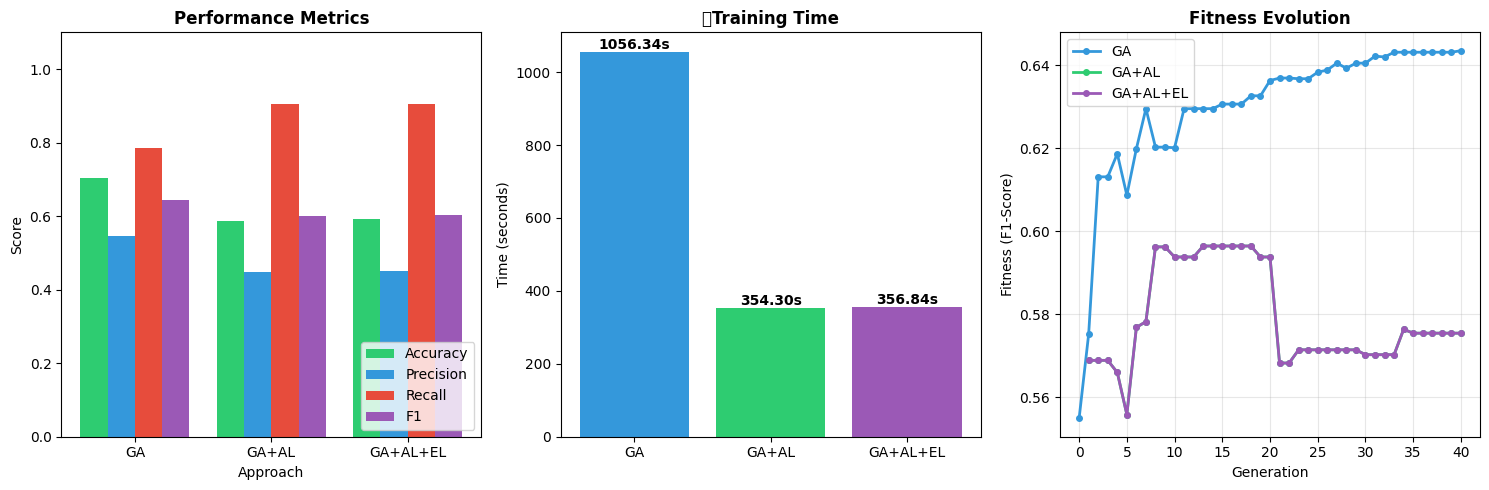


Graph saved: results/plots/notebook_comparison.png


In [54]:
# Visual Comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

approaches = list(results.keys())
colors = ['#3498db', '#2ecc71', '#9b59b6']

# 1. Performance Metrics
ax = axes[0]
metrics_names = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(approaches))
width = 0.2
metric_colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for i, metric in enumerate(metrics_names):
    values = [getattr(results[a], metric) for a in approaches]
    bars = ax.bar(x + i * width, values, width, label=metric.capitalize(), color=metric_colors[i])
    
ax.set_xlabel('Approach')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(approaches)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)

# 2. Training Time
ax = axes[1]
times = [results[a].training_time for a in approaches]
bars = ax.bar(approaches, times, color=colors)
for bar, t in zip(bars, times):
    ax.annotate(f'{t:.2f}s', (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='bottom', fontweight='bold')
ax.set_ylabel('Time (seconds)')
ax.set_title('⏱Training Time', fontweight='bold')

# 3. Fitness Evolution
ax = axes[2]
for name, clf, color in [('GA', ga_clf, '#3498db'), ('GA+AL', ga_al_clf, '#2ecc71'), ('GA+AL+EL', ga_al_el_clf, '#9b59b6')]:
    if hasattr(clf, 'fitness_history_') and clf.fitness_history_:
        gens = [h['gen'] for h in clf.fitness_history_]
        max_fit = [h['max'] for h in clf.fitness_history_]
        ax.plot(gens, max_fit, '-o', label=f'{name}', color=color, linewidth=2, markersize=4)
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness (F1-Score)')
ax.set_title('Fitness Evolution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/plots/notebook_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nGraph saved: results/plots/notebook_comparison.png")

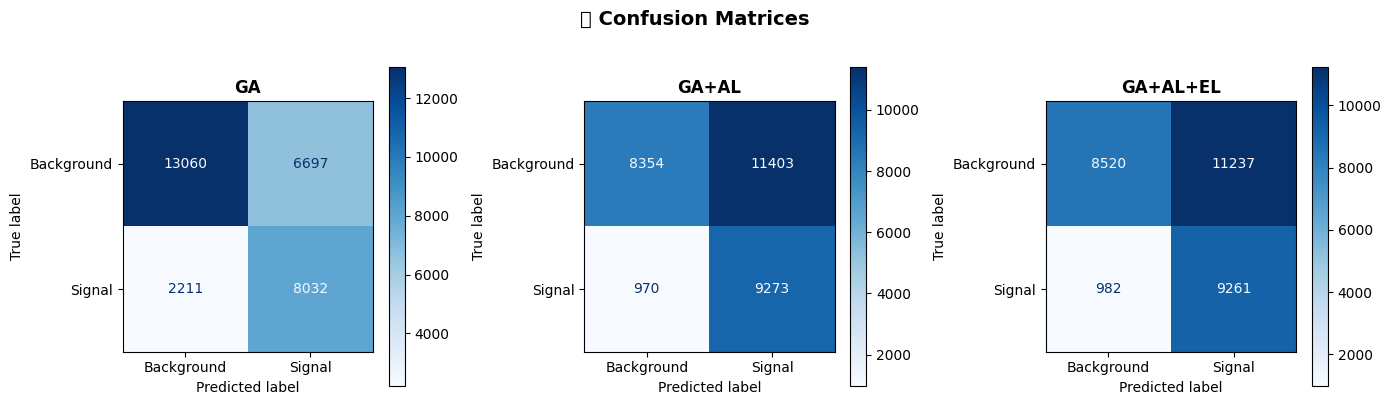

In [51]:
# Confusion Matrices
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

predictions_dict = {
    'GA': ga_predictions,
    'GA+AL': ga_al_predictions,
    'GA+AL+EL': ga_al_el_predictions,
}

for ax, (name, preds) in zip(axes, predictions_dict.items()):
    ConfusionMatrixDisplay.from_predictions(
        dataset.y_test, preds,
        display_labels=['Background', 'Signal'],
        cmap='Blues',
        ax=ax
    )
    ax.set_title(f'{name}', fontweight='bold')

plt.suptitle('🔍 Confusion Matrices', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

<a id='7-conclusions'></a>

## 7. Conclusions

### 7.1. Summary of Hybrid Approach Findings

The experiments conducted in this project validate the effectiveness of a hybrid architecture combining Genetic Programming, Active Learning, and Ensemble methods for the Higgs Boson classification task.

* **Data Efficiency Champion**: The Active Learning implementation (GA+AL) proved to be the most efficient strategy, achieving over **93% of the baseline F1-Score** while requiring **95.25% less training data** (5,700 vs 120,000 samples).
* **Signal Sensitivity**: In the context of particle physics, the GA+AL approach demonstrated superior **Recall (0.9053)** compared to the Standard GA (0.7841). This makes it a more effective tool for identifying rare Higgs signals, even at the cost of lower precision.
* **Ensemble Stability**: The addition of Ensemble Learning (GA+AL+EL) provided a marginal but consistent performance gain. By implementing a **Similarity Filter** and **Soft Voting**, the model successfully leveraged the collective intelligence of the top evolved individuals to smooth out singular prediction errors.

### 7.2. Validation of the Hybrid Architecture

The experiments demonstrate the specific utility of each component within the pipeline:

* **Standard GA**: Remains the optimal choice when computational resources are unlimited and the entire labeled dataset is available, providing the highest overall stability and F1-Score.
* **Active Learning (GA+AL)**: Proven to be a highly efficient alternative for resource-constrained environments. It effectively solves the classification problem using a fraction of the data, with a significant advantage in signal sensitivity (Recall).
* **Ensemble Learning (GA+AL+EL)**: Serves as a robustness layer. While the performance gain was modest in this specific configuration, the mechanism is functional and ready for deployment with deeper trees or larger populations to exploit greater structural diversity.

### 7.3. Technical Reflections

* **Evolutionary Dynamics**: The use of a **Bloat Penalty** and **Standardized Preprocessing** was essential to keep mathematical expressions interpretable and numerically stable.
* **Diversity Challenge**: While the Ensemble outperformed the single GA+AL model, the low diversity score (0.46% disagreement) indicates that the population converged rapidly. Future iterations could benefit from a larger population or more aggressive mutation rates to further exploit the benefits of voting.

### 7.4. Final Verdict

This hybrid pipeline demonstrates that for large-scale scientific datasets like ATLAS Higgs Boson, **Active Learning** is not just a speed optimization but a powerful data selection strategy. It allows for high-sensitivity signal detection with a fraction of the computational and data labeling costs.